# Travail pratique 3 - IFT-4022/7022

Dans ce travail, nous étudions les systèmes de question-réponse (QA) appliqués au domaine de Sherlock Holmes que nous avons utilisé pour le travail pratique #2. L’objectif est de comparer deux approches QA basées sur un modèle de langue (LLM) :
* **Question-réponse sans RAG** : le modèle répond uniquement à partir de ses connaissances internes.
* **Question-réponse avec RAG** : le modèle génère une réponse après récupération de passages pertinents dans les textes.

Dans ce travail, nous réutiliserons le matériel fourni dans le TP #2, incluant :
* **les six livres** de Sherlock Holmes ;
* les **50 questions** que nous avons rédigées;
* les fichiers et **fonctions utilitaires nécessaires**.

In [1]:
# Installation des bibliothèques nécessaires (à exécuter une seule fois)
!pip install transformers torch sentence-transformers faiss-cpu langchain langchain-community langchain-text-splitters  chromadb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 9.5 MB/s eta 0:00:0

In [2]:
# Imports nécessaires
import os
import re
import json
import string
import requests
import torch
from collections import Counter
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
import warnings
warnings.filterwarnings('ignore')

## 1. Préparation du corpus de Sherlock Holmes (à exécuter)

Dans cette section, nous téléchargeons et préparons les œuvres complètes utilisées pour l’expérimentation, exactement comme dans le second travail pratique. Les six livres proviennent du Project Gutenberg, et nous appliquons les mêmes étapes de nettoyage afin d’obtenir un corpus homogène et directement exploitable par les systèmes de question-réponse. Le résultat est une longue chaîne de caractères qui contient le texte des six livres.

In [21]:
books = {
    "The Sign of the Four": "https://www.gutenberg.org/files/2097/2097-0.txt",
    "The Adventures of Sherlock Holmes": "https://www.gutenberg.org/files/1661/1661-0.txt",
    "The Memoirs of Sherlock Holmes": "https://www.gutenberg.org/files/834/834-0.txt",
    "The Hound of the Baskervilles": "https://www.gutenberg.org/files/2852/2852-0.txt",
    "His Last Bow": "https://www.gutenberg.org/files/2350/2350-0.txt",
    "The Case-Book of Sherlock Holmes": "https://www.gutenberg.org/files/221/221-0.txt"
}

def download_sherlock_dataset(books_to_process):
    data = []

    for title, url in books_to_process.items():
        response = requests.get(url)

        if response.status_code == 200:
            text = response.text

            # Cette expression est plus robuste que ce qui était attendu dans le premier travail pratique
            header_regex = r"(?s)^.*?\*{3}\s*START OF\b.*?\r?\n?\*{3}\s*\r?\n"
            header_pattern = re.compile(header_regex, flags=0)
            clean_text = header_pattern.sub("", text)

            toc_regex = r"(?ims)^\s*contents\s*$.*?^\s*$"
            toc_pattern = re.compile(toc_regex, flags=0)
            clean_text = toc_pattern.sub("", clean_text)

            regex_license_llm = r"(?im)^\s*\*{3} END OF\b.*[\s\S]*\Z"
            license_llm_pattern = re.compile(regex_license_llm, flags=0)
            clean_text = license_llm_pattern.sub("", clean_text)

            # To make it simpler to learn text without learning new lines
            clean_text = re.sub(r"\r\n\r\n", "\n", clean_text)
            clean_text = re.sub(r"\r\n", "\n", clean_text)

            print("current:", len(clean_text))
            data.append(clean_text)
            print(f"Downloaded: {title}")
        else:
            print(f"Failed to download: {title}")

    print("full:", len("\n".join(data)))

    return "\n".join(data)

In [22]:
sherlock_text = download_sherlock_dataset(books_to_process=books)

current: 230788
Downloaded: The Sign of the Four
current: 559159
Downloaded: The Adventures of Sherlock Holmes
current: 567004
Downloaded: The Memoirs of Sherlock Holmes
current: 352045
Downloaded: The Hound of the Baskervilles
current: 322113
Downloaded: His Last Bow
current: 609080
Downloaded: The Case-Book of Sherlock Holmes
full: 2640194


## 2. Fonction pour le chargement du modèle

Dans cette section, nous chargeons un modèle de langue (LLM) instruction-tuned, qui servira aux deux approches de question-réponse : **sans RAG** et **avec RAG**.

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

def get_device():
    if torch.cuda.is_available(): # GPU NVIDIA
        return "cuda"
    elif torch.mps.is_available(): # Mac M2, M3, M4 (M1?)
        return "mps"
    else :
        return "cpu" # Pas de GPU compatible - Sinon ajouter une autre condition si vous en avez un

In [5]:
get_device()

'cuda'

In [6]:
def load_model(model_path):
    device = get_device()
    model = AutoModelForCausalLM.from_pretrained(model_path, dtype=torch.bfloat16 if device=="cuda" or "mps" else None, device_map="auto")
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.config.pad_token_id = tokenizer.pad_token_id
    return tokenizer, model

Dans la suite du travail, nous utiliserons le modèle **SmolLM2-1.7B-Instruct** proposé par HuggingFaceTB.

Ce choix est motivé par plusieurs considérations méthodologiques et pratiques, en cohérence avec les objectifs du TP et les notions abordées dans le cours.

#### Taille du modèle et contraintes computationnelles

SmolLM2-1.7B-Instruct est un modèle de taille modérée (1,7 milliard de paramètres), ce qui présente plusieurs avantages dans le cadre du travail pratique :

- Il est **exécutable localement** sur un GPU standard, sans nécessiter d’infrastructure lourde.
- Il permet des **expérimentations rapides et reproductibles**, indispensables pour comparer différentes stratégies de prompting et de RAG.
- Il met en évidence les **limitations des petits modèles**, notamment leur forte sensibilité au prompt et leur dépendance au contexte fourni, ce qui constitue un point central du cours.

L’objectif du TP n’est pas d’atteindre des performances maximales, mais d’analyser l’impact des choix de conception (prompting, retrieval, chunking). Un modèle de taille intermédiaire est donc plus pertinent qu’un très grand modèle pré-entraîné.

#### Modèle instruction-tuned

La version *Instruct* du modèle a été choisie car elle est spécifiquement entraînée pour :

- suivre des **instructions explicites**,
- respecter des **contraintes de format de sortie**,
- produire des réponses structurées dans des scénarios de question-réponse.

Ces propriétés sont particulièrement adaptées :
- aux tâches de **question-réponse factuel**,
- à l’étude de la **sensibilité aux prompts**,
- aux scénarios RAG imposant des règles strictes (répondre uniquement à partir du contexte, produire une réponse courte, déclarer l’absence d’information).

#### Pertinence pour l’étude du RAG

SmolLM2-1.7B-Instruct n’est pas un modèle de raisonnement avancé, ce qui en fait un bon candidat pour analyser :

- la dépendance réelle du modèle aux **passages récupérés**,
- l’impact du **retrieval** sur la qualité des réponses,
- les phénomènes de **contamination par les connaissances internes** lorsque le prompt ou le contexte sont mal contrôlés.

Ces caractéristiques permettent d’étudier concrètement les compromis entre :
- réponses basées sur les **connaissances internes** du modèle (Non-RAG),
- réponses conditionnées par de l’**information externe** injectée via RAG.

#### Chargement en torch.bfloat16

Le modèle est chargé en **bfloat16** afin d’optimiser l’utilisation de la mémoire GPU tout en conservant une stabilité numérique satisfaisante :

- le format bfloat16 réduit significativement l’empreinte mémoire par rapport au float32,
- il est bien supporté par les GPU modernes,
- il n’entraîne pas de dégradation notable des performances pour les tâches de génération et de compréhension.

Ce choix permet ainsi de maintenir un bon compromis entre **efficacité computationnelle**, **stabilité numérique** et **qualité des résultats**.

## 3. Fonctions RAG - Indexation et récupération

Dans cette section, on met en place le pipeline RAG.  

1. **Découpage du texte en chunks**  
   On découpe le corpus en petits morceaux pour que chaque chunk reste cohérent et facile à retrouver.  
   Cela évite de mélanger plusieurs scènes et permet au système de localiser plus précisément l'information.

2. **Création d'embeddings pour chaque chunk**  
   Chaque chunk est transformé en vecteur.  
   Ce format permet de mesurer à quel point un passage ressemble à une question, ce qui est impossible avec du texte brut.

3. **Indexation FAISS pour une recherche rapide**  
   FAISS agit comme un moteur de recherche, mais pour des vecteurs.  
   Il permet de retrouver les passages les plus proches en une fraction de seconde, même dans de gros corpus.

4. **Récupération des passages pertinents**  
   Une fois la question encodée, on récupère les passages les plus proches sémantiquement.  
   Ces extraits servent ensuite de contexte au modèle génératif.

### Architecture RAG

- **Embedding model : intfloat/e5-large-v2**
  - Un des meilleurs modèles pour la recherche dense.  
  - Il aligne très bien les questions et les passages grâce à son format "query:" / "passage:".

- **Taille des chunks : 500 tokens avec 50 tokens d'overlap**  
  - 500 tokens donnent juste assez de contexte pour capter les détails importants.  
  - L'overlap évite de couper une information critique en plein milieu.
  - On tester aussi avec 100 tokens d'overlap si jamais des réponses ratées viennent d'informations coupée à la frontière entre deux chunks.

- **Index : FAISS avec IndexFlatIP**  
  - Très rapide et parfaitement adapté à des embeddings L2 normalisés.  
  - Le produit scalaire (Inner Product) est alors équivalent à la similarité cosinus.

- **Top-k : 5 passages les plus pertinents**  
  - Trop peu de passages -> risque de rater la réponse.  
  - Trop de passages -> prompt surchargé.  
  - 5 est un bon équilibre dans la plupart des cas.

In [7]:
def create_token_chunks(text, tokenizer, chunk_tokens=500, overlap_tokens=50):
    ids = tokenizer.encode(text, add_special_tokens=False)
    chunks = []
    start = 0
    while start < len(ids):
        end = min(start + chunk_tokens, len(ids))
        chunk_ids = ids[start:end]
        chunks.append(tokenizer.decode(chunk_ids))
        start = end - overlap_tokens
        if start < 0:
            start = 0
        if end == len(ids):
            break
    print(f"Chunks (token-based) créés : {len(chunks)}")
    return chunks

In [8]:
def create_embeddings(chunks, model_name="intfloat/e5-large-v2"):
    """
    Encode les chunks en vecteurs d'embeddings avec e5-large-v2.
    """
    global embedding_model
    embedding_model = SentenceTransformer(model_name)

    encoded = embedding_model.encode(
        [f"passage: {c}" for c in chunks],
        normalize_embeddings=True,
        show_progress_bar=True
    )

    print(f"Embeddings créés : shape = {encoded.shape}")
    return np.array(encoded, dtype="float32")

In [9]:
def create_faiss_index(embeddings):
    """
    Crée un index FAISS pour la recherche vectorielle.
    """
    d = embeddings.shape[1]

    # Index basé sur Inner Product (équivalent au cosine si embeddings normalisés)
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)

    print(f"Index FAISS créé avec {index.ntotal} vecteurs")
    return index

In [10]:
def retrieve_relevant_chunks(question, index, chunks, top_k=5):
    """
    Récupère les top_k chunks les plus pertinents pour une question.
    """
    global embedding_model

    # Encode la question
    q_emb = embedding_model.encode(
        f"query: {question}",
        normalize_embeddings=True
    ).astype("float32")

    # Recherche FAISS
    scores, idx = index.search(np.array([q_emb]), k=top_k)

    # Retourne les chunks correspondants
    return [chunks[i] for i in idx[0]]

In [11]:
def build_rag_pipeline(text, tokenizer, chunk_tokens=500, overlap_tokens=100):
    """
    Pipeline complet:
    1. Chunks
    2. Embeddings
    3. Index FAISS

    Initialise les variables globales.
    """
    global text_chunks, embedding_matrix, faiss_index

    print("Construction du pipeline RAG (token-based)")
    text_chunks = create_token_chunks(text, tokenizer, chunk_tokens=chunk_tokens, overlap_tokens=overlap_tokens)
    embedding_matrix = create_embeddings(text_chunks)
    faiss_index = create_faiss_index(embedding_matrix)
    print("Pipeline RAG prêt.")

### 4. Construction des prompts et génération de réponses

Dans cette section, nous mettons en place la logique complète de question-réponse en séparant explicitement trois étapes :

1.  **Construction du prompt** (Non-RAG vs RAG)
2.  **Génération** via le modèle de langage
3.  **Post-traitement** (décodage et nettoyage de la sortie)

**Cette séparation permet une analyse rigoureuse des erreurs :**
* Si la réponse attendue n’apparaît pas dans les passages récupérés $\rightarrow$ **problème de retrieval**.
* Si la réponse est présente mais incorrecte $\rightarrow$ **problème de génération ou de suivi du prompt**.
* Si la réponse est correcte mais pénalisée par l’évaluation $\rightarrow$ **limite des métriques exactes**.

> Cette démarche est directement inspirée des principes méthodologiques du cours sur le **débogage des pipelines RAG**.


#### 4.1 Choix des paramètres de génération

Les paramètres de génération sont choisis pour une tâche de **question-réponse factuelle**, où la priorité est la stabilité et la reproductibilité plutôt que la créativité.

* `do_sample = False`
    * La génération est déterministe (pas d’échantillonnage).
    * Cela permet d’évaluer les différences entre Non-RAG et RAG sans variance aléatoire, conformément aux bonnes pratiques d’évaluation vues au cours.
* `temperature` et `top_p`
    * Ces paramètres n’ont d’effet significatif que lorsque l’échantillonnage est activé.
    * Ils sont conservés paramétrables pour permettre des tests ultérieurs, mais restent neutres dans la configuration actuelle.
* `max_new_tokens`
    * Cette valeur borne la longueur maximale de génération afin d’éviter :
        1.  La copie accidentelle du contexte.
        2.  Les réponses verbeuses ou explicatives.
        3.  Les dérives hors format imposé.
    * Elle ne force pas la troncature de la réponse finale, mais limite le budget de génération.


#### 4.2 Prompt pour l’approche Non-RAG

Le prompt Non-RAG est conçu pour évaluer les capacités du modèle **sans contexte externe**, en s’appuyant uniquement sur :
* Ses connaissances issues du **pré-entraînement**.
* Sa capacité à suivre des consignes grâce à l’*instruction tuning*.

**Le prompt repose sur plusieurs notions vues au cours :**

1.  **Role prompting :** Le modèle est explicitement positionné comme expert du canon de Sherlock Holmes, ce qui oriente son comportement et son registre de réponse.
2.  **Instruction prompting structuré :** Les règles sont formulées de manière explicite et hiérarchisée (liste numérotée), ce qui améliore l’adhérence aux contraintes.
3.  **Contraintes de format :** La sortie est limitée à un *answer span* minimal (nom ou groupe nominal), sur une seule ligne, sans phrase complète. Cela facilite l’évaluation automatique par F1 / EM.
4.  **Gestion de l’incertitude :** L’instruction “I don’t know” est utilisée comme mécanisme de réduction des hallucinations lorsque la réponse est absente ou ambiguë.

> Cette configuration permet d’observer les **forces et limites du modèle en mode closed-book**.

In [12]:
def question_prompt_builder(question):
    """
    Construit un prompt NON-RAG.
    Objectif:
    - Faire répondre le modèle à partir de ses connaissances internes (préentraînement).
    - Forcer un format de sortie "atomique": uniquement un span minimal (nom / GN).
    Notions du cours mobilisées:
    - Role prompting: spécialiser le modèle (expert Holmes)
    - Instruction prompting structuré: règles explicites et hiérarchisées
    - Contraintes de format: une ligne, pas de phrase complète
    - Gestion de l'incertitude: "I don't know" pour limiter les hallucinations
    """
    system_content = """TASK: Answer factual questions about the Sherlock Holmes canon by Sir Arthur Conan Doyle.

ROLE:
You are a domain expert with precise knowledge of the canonical Sherlock Holmes stories
(characters, locations, objects, events).

OUTPUT CONSTRAINTS (follow strictly):
1. Output ONLY the minimal answer span (a name or short noun phrase).
2. Do NOT use a full sentence.
3. Do NOT add explanations, qualifiers, or background.
4. Use ONLY information from the original stories (no adaptations).
5. If the answer is unknown or ambiguous, output exactly: I don't know

FORMAT:
- One line
- No prefix (no "A:", no quotation marks)

EXAMPLES:
Q: What musical instrument does Holmes play?
A: The violin

Q: Who is Holmes's landlady?
A: Mrs. Hudson

Q: What is the name of Holmes's brother?
A: Mycroft Holmes

Remember: precision > verbosity. Return only the answer span."""

    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt

#### 4.3 Prompt pour l’approche RAG

Le prompt RAG transforme la tâche en un problème de **reading comprehension** guidée par un contexte externe.

Les passages récupérés par FAISS sont injectés explicitement dans le prompt, et le modèle est contraint de répondre **uniquement** à partir de ces passages.

**Les principes clés mobilisés sont :**

* **Retrieval-Augmented Generation (RAG) :** La génération est conditionnée par des informations externes issues du corpus, plutôt que par la mémoire interne du modèle.
* **Anti-contamination / grounding :** Le prompt interdit explicitement l’usage de connaissances externes au contexte fourni. Cela réduit les hallucinations, mais rend la qualité de la réponse dépendante du retrieval.
* **Answer span extractif :** Le modèle doit produire un texte court, présent tel quel dans les passages. Cette contrainte rapproche le comportement du modèle d’un système d’extraction, même si la génération reste libre.
* **Fallback strict (“I don’t know”) :** Si l’information n’apparaît pas explicitement dans les passages, le modèle doit déclarer l’absence de réponse. Ce mécanisme limite les réponses inventées, au prix d’un rappel parfois plus faible lorsque le retrieval échoue.

> Cette approche correspond au cas standard de **RAG contrôlé**, tel que présenté au cours.


In [78]:
def rag_prompt_builder(question, top_k=5):
    """
    Construit un prompt RAG (question + passages récupérés).

    Objectif:
    - Faire répondre le modèle UNIQUEMENT à partir des passages fournis.
    - Forcer un format de sortie "atomique": uniquement un span minimal (nom / GN).
    - Réduire les hallucinations via un fallback strict: "I don't know" si absent.

    Notions mobilisées:
    - RAG: réponse conditionnée par contexte externe
    - Anti-contamination prompting: "ONLY passages"
    - Contraintes de format: une ligne, pas de phrase complète
    - Gestion de l'incertitude: "I don't know"
    """
    relevant_chunks = retrieve_relevant_chunks(question, faiss_index, text_chunks, top_k=top_k)
    context = "\n\n".join([f"[Passage {i+1}]\n{chunk}" for i, chunk in enumerate(relevant_chunks)])

    system_content = f"""TASK: Answer a factual question using ONLY the provided passages from the Sherlock Holmes canon by Sir Arthur Conan Doyle.

ROLE:
You are an extractive reading-comprehension system. You must ground your answer in the passages.

DEFINITION — ANSWER SPAN:
An answer span is a short, contiguous piece of text that directly answers the question.
It is usually:
- a name (e.g., "Mrs. Hudson", "Mycroft Holmes"),
- or a short noun phrase (e.g., "the violin", "221B Baker Street").

An answer span is NOT:
- a full sentence,
- an explanation,
- a reformulation,
- or any text that is not explicitly present in the passages.

CRITICAL RULES (follow strictly):
1. Use ONLY information explicitly stated in the passages below. No outside knowledge.
2. Output ONLY the answer span, exactly as it appears in the passages.
3. Do NOT output a full sentence.
4. Do NOT add explanations, qualifiers, or background.
5. Do NOT write prefixes like "Answer:", "Answer span:", "According to...", or "The answer is...".
6. If the passages do NOT explicitly contain the answer span, output exactly: I don't know

FORMAT:
- One line
- Answer span only
- No prefix, no quotation marks

EXAMPLES:
Q: What musical instrument does Holmes play?
A: the violin

Q: Who is Holmes's landlady?
A: Mrs. Hudson

Q: What is the name of Holmes's brother?
A: Mycroft Holmes

PASSAGES:
{context}

Remember: return ONLY the answer span, nothing else."""

    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": f"QUESTION: {question}"}
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt

#### 4.4 Orchestrateur

In [75]:
def answer_with_context(tokenizer, model, prompt_builder, max_new_tokens=30, **kwargs):
    question = kwargs.get("question", "")

    if prompt_builder is rag_prompt_builder:
        top_k = kwargs.get("top_k", 5)
        prompt = prompt_builder(question, top_k=top_k)
    else:
        prompt = prompt_builder(question)

    device = get_device()
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=kwargs.get("do_sample", False),
            temperature=kwargs.get("temperature", 0.1), # Tant que do_sample est à False, temperature et top_p seront ignorés
            top_p=kwargs.get("top_p", 0.9),
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    gen_ids = outputs[0][inputs["input_ids"].shape[1]:]
    answer = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    # Retirer TOUS les préfixes problématiques
    prefixes = [
    r'^\s*A:\s*',
    r'^\s*Answer:\s*',
    r'^\s*(?:the\s+)?answer\s*(?:span)?\s*(?:is)?\s*[:\-]\s*',
    r'^\s*(?:the\s+)?answer\s*(?:span)?\s*(?:is)?\s+',
    r'^\s*PASSAGE\s*\d*:?\s*',
    r'^\s*According to.*?,\s*',
    r'^\s*Based on.*?,\s*',
    r'^\s*In the (?:story|passage).*?,\s*',
    r'^\s*The [a-z]+ (?:that|which|who)\s+',
    ]
    for p in prefixes:
        answer = re.sub(p, '', answer, flags=re.IGNORECASE)


    answer = answer.strip().strip('.,;:"\'')

    return answer

#### Intérêt de la séparation retrieval / génération

Cette architecture permet d’analyser précisément les échecs observés lors de l’évaluation :

1.  **RAG meilleur :** Le modèle Non-RAG hallucine ou confond des entités proches. La présence du passage pertinent permet au modèle RAG de corriger l’erreur factuelle.
2.  **Non-RAG meilleur :** Le retrieval échoue ou récupère des passages bruités. Le modèle RAG, contraint par le contexte, abandonne une réponse correcte qu’il aurait pu produire sans RAG.
3.  **Échec des deux approches :** L’information est absente ou mal exprimée dans le corpus, ou la question nécessite un niveau de précision que le modèle et/ou le retrieval ne capturent pas.

> **Conclusion :** Cette analyse met en évidence le compromis central du RAG : **réduction des hallucinations vs dépendance à la qualité du retrieval**, notion clé du cours.

## 5. Fonctions de chargement des questions et outils d’évaluation

Cette section regroupe les utilitaires nécessaires pour exécuter et évaluer vos modèles de question-réponse.

La première (*load_entries*) fonction permet de charger les 50 questions fournies pour le travail pratique. Ce sont les mêmes que celles utilisées dans le TP #2. Ces questions serviront à évaluer les performances des deux approches (avec et sans RAG).

Nous fournissons aussi la fonction qui permet de sauvegarder les réponses ainsi que la fonction qui permet d'itérer sur les questions. Le valeur de *max_new_tokens* peut être modifiée si elle est trop contraignante.



In [15]:
import json

def load_entries(path):
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    if not isinstance(data, list):
        raise ValueError(f"Question file must contain a list of objects. Got: {type(data)}")
    return data

def save_answers(questions_answers, output_dir, out_file_name, display=True):
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, out_file_name), "w", encoding="utf-8") as out:
        for index, question, answer, expected_answer in questions_answers:
            out.write(f"Q: {question}\nA: {answer}\nExpected:{expected_answer}\n{'-' * 60}\n")
            if display:
                print(f"Q{index}: {question}\nA: {answer}\nExpected:{expected_answer}\n{'-' * 60}")

In [16]:
def test_on_questions(tokenizer, model, question_file, prompt_builder, out_file_name, output_dir="results", **kwargs):
    entries = load_entries(question_file)
    results = []
    for i, entry in enumerate(entries):
        question = entry.get("question", "")
        answer = answer_with_context(tokenizer, model, prompt_builder, question=question, max_new_tokens=512, **kwargs)
        expected_answer = entry.get("answer", "")
        results.append((i, question, answer, expected_answer))
    save_answers(results, output_dir, out_file_name, display=True)
    return results

## 6. Exécution des expériences (RAG vs. non-RAG)

Cette section orchestre l’exécution complète des deux configurations (Non-RAG et RAG), puis produit une première évaluation quantitative + quelques vérifications qualitatives (sanity checks, inspection du retrieval).
Elle est conçue pour être modulaire : vous pouvez changer les paramètres (top-k, température, max tokens, etc.) sans toucher aux fonctions précédentes.

In [ ]:
# Paramètres globaux

questions_file = "data/questions_sherlock.json"   # issu du TP2
model_path = "HuggingFaceTB/SmolLM2-1.7B-Instruct"  # ou un chemin local

# Réglages QA (reproductibles)
GEN_KWARGS = dict(
    do_sample=False,      # déterministe
    temperature=0.1,      # peu d'effet si do_sample=False
    top_p=0.9,            # peu d'effet si do_sample=False
)

MAX_NEW_TOKENS = 256       # suffisant pour une "réponse span"
OUTPUT_DIR = "results"

# Réglages RAG
TOP_K = 5                 # top-k passages récupérés

In [18]:
# Chargement du modèle

tokenizer, model = load_model(model_path)
device = get_device()

print("Device:", device)
print("Model:", model_path)
print("Tokenizer pad_token_id:", tokenizer.pad_token_id)
print("Model pad_token_id:", model.config.pad_token_id)
print("Tokenizer eos_token_id:", tokenizer.eos_token_id)

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Device: cuda
Model: HuggingFaceTB/SmolLM2-1.7B-Instruct
Tokenizer pad_token_id: 2
Model pad_token_id: 2
Tokenizer eos_token_id: 2


In [ ]:
# Construction du pipeline RAG

from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

build_rag_pipeline(sherlock_text, tokenizer, chunk_tokens=500, overlap_tokens=100) # On prend finalement overlap = 100 pour s'éviter que des réponses “ratées” 
                                                                                   # d’une information coupée à la frontière entre deux chunks

Construction du pipeline RAG (token-based)


Token indices sequence length is longer than the specified maximum sequence length for this model (648530 > 8192). Running this sequence through the model will result in indexing errors


Chunks (token-based) créés : 1622


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Batches:   0%|          | 0/51 [00:00<?, ?it/s]

Embeddings créés : shape = (1622, 1024)
Index FAISS créé avec 1622 vecteurs
Pipeline RAG prêt.


In [65]:
no_rag_results = test_on_questions(
    tokenizer, model,
    question_file=questions_file,
    prompt_builder=question_prompt_builder,
    out_file_name="no_rag_answers.txt",
    output_dir=OUTPUT_DIR,
    **GEN_KWARGS
)

Q0: Where do Sherlock Holmes and Dr. Watson live?
A: 221B Baker Street
Expected:221B Baker Street, London.
------------------------------------------------------------
Q1: Who is Sherlock Holmes' loyal friend and chronicler?
A: Watson
Expected:Dr. John H. Watson.
------------------------------------------------------------
Q2: Who is considered 'The Woman' by Sherlock Holmes?
A: Mycroft Holmes
Expected:Irene Adler.
------------------------------------------------------------
Q3: Which story features the Red-Headed League?
A: The Red-Headed League
Expected:The Adventure of the Red-Headed League.
------------------------------------------------------------
Q4: What is the primary occupation of Sherlock Holmes?
A: The primary occupation of Sherlock Holmes is a consulting detective
Expected:Consulting detective.
------------------------------------------------------------
Q5: Who is Sherlock Holmes' arch-nemesis?
A: Professor Moriarty
Expected:Professor James Moriarty.
--------------------

In [79]:
rag_results = test_on_questions(
    tokenizer, model,
    question_file=questions_file,
    prompt_builder=rag_prompt_builder,
    out_file_name="rag_answers.txt",
    output_dir=OUTPUT_DIR,
    top_k=TOP_K,
    **GEN_KWARGS
)

Q0: Where do Sherlock Holmes and Dr. Watson live?
A: 221B Baker Street
Expected:221B Baker Street, London.
------------------------------------------------------------
Q1: Who is Sherlock Holmes' loyal friend and chronicler?
A: Watson
Expected:Dr. John H. Watson.
------------------------------------------------------------
Q2: Who is considered 'The Woman' by Sherlock Holmes?
A: Irene Adler
Expected:Irene Adler.
------------------------------------------------------------
Q3: Which story features the Red-Headed League?
A: The Red-Headed League
Expected:The Adventure of the Red-Headed League.
------------------------------------------------------------
Q4: What is the primary occupation of Sherlock Holmes?
A: detective
Expected:Consulting detective.
------------------------------------------------------------
Q5: Who is Sherlock Holmes' arch-nemesis?
A: Milverton
Expected:Professor James Moriarty.
------------------------------------------------------------
Q6: What musical instrument d

### À première vue, Non-RAG et RAG n’échouent pas de la même manière.

#### Non-RAG (réponses “closed-book”)

* **Points forts :** Quand le fait est très connu et bien ancré dans le pré-entraînement (ex. *violin*, *Mrs. Hudson*, *Mycroft Holmes*, *London*, *Boxing*), le modèle répond correctement, parfois même avec un intitulé plus complet (*consulting detective*).
* **Erreurs typiques :** Beaucoup de **hallucinations/confusions factuelles** dès que la question demande un détail précis ou moins “stéréotypé” du canon. On voit des substitutions d’entités plausibles mais fausses (*Mycroft Holmes* au lieu d’*Irene Adler*, *Amber* au lieu de *Blue Carbuncle*, etc.).
* **Signature globale :** Modèle **plus autonome** (il répond presque toujours), mais **plus risqué** sur les faits fins car il comble les trous par des associations.


#### RAG (réponses “grounded” sur passages)

* **Gains visibles :** RAG corrige plusieurs erreurs factuelles nettes de Non-RAG quand les passages récupérés contiennent l’information (ex. *Irene Adler*, *Grimpen Mire*, *Blue Carbuncle*, *Diogenes Club*, *Silver Blaze*). C’est typique d’un RAG qui sert d’ancrage textuel.
* **Erreurs typiques :** Lorsque le **retrieval est bruité/incomplet**, le modèle est “tiré” vers le mauvais contexte et produit une réponse incorrecte mais liée aux passages (ex. *Milverton* au lieu de *Moriarty*, *Baker Street* au lieu de *London*, *hypodermic syringe* au lieu de *magnifying glass*).
* **Signature globale :** Modèle **moins hallucinant**, mais **plus dépendant** de la qualité des top-k passages. Le RAG peut donc **dégrader** une question que Non-RAG réussissait si le retrieval ne ramène pas la bonne preuve.


Grosso-modo :
* **Non-RAG :** “Je sais / je devine” $\rightarrow$ plus de réponses, mais plus d’erreurs factuelles.
* **RAG :** “Je réponds avec ce que je vois” $\rightarrow$ meilleures corrections factuelles quand le contexte est bon, mais erreurs possibles quand le retrieval échoue.

### Limites spécifiques du modèle SmolLM2-1.7B-Instruct

L’utilisation de **SmolLM2-1.7B-Instruct** met clairement en évidence les limites des modèles de petite taille en matière de **respect strict des contraintes de prompt**.

Malgré un prompt fortement structuré (règles explicites, contraintes numérotées, exemples), le modèle :

* Produit encore des **phrases complètes** au lieu d’un *answer span*.
* Ajoute des **reformulations ou explications** non demandées.
* Viole ponctuellement la règle **“ONLY passages”** en mode RAG.
* Et peine à appliquer systématiquement le fallback **“I don’t know”**.

**Ces comportements s’expliquent par :**
1.  Une **capacité limitée de suivi d’instructions complexes**.
2.  Une tendance plus forte à **sur-généraliser** ou à compléter la réponse par plausibilité.
3.  Une difficulté à maintenir simultanément plusieurs contraintes (format, source, concision).

> **Pourquoi c'est critique en RAG :**
> Ces limites sont particulièrement visibles ici, car le modèle doit gérer une charge cognitive élevée en devant à la fois :
> * Ignorer ses connaissances internes,
> * Raisonner uniquement à partir du contexte,
> * Et respecter un format de sortie extrêmement contraint.

## 7. Évaluation quantitatives des réponses

Cette section évalue quantitativement les réponses générées en Non-RAG et en RAG.
On utilise deux familles de mesures :
	- des mesures lexicales (précision, rappel, F1) basées sur le recouvrement de mots après normalisation ;
	- une mesure sémantique (similarité cosinus) basée sur des embeddings (intfloat/e5-large-v2).
  
L’idée est de capturer à la fois la correspondance exacte (utile pour des answer spans) et une proximité de sens (utile si la formulation diffère légèrement).

In [80]:
import string
import re
from collections import Counter

def remove_articles(text):
    return re.sub(r'\b(a|an|the)\b', ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Mettre en minuscule et retirer la ponctuation, des déterminants and les espaces."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

La normalissation met en minuscules, enlève ponctuation, articles (a/an/the), et compresse les espaces. Ainsi "The Blue Carbuncle." et "blue carbuncle" deviennent par exemple très proches. Mais cela peut masquer des différences importantes (ex. “Times” vs “Daily Telegraph” restent différents, mais “a hansom” vs “a hansom cab” peut donner un F1 partiel).

In [81]:
def evaluate_f1(ground_truth, prediction):
    """Normalise les 2 textes, trouve ce qu'il y a en commun et estime précision, rappel et F1."""
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0, 0.0, 0.0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return precision, recall, f1

La Precision est la proportion de tokens prédits qui sont dans la vérité terrain. Le Recall la proportion de tokens de la vérité terrain retrouvés. La F1 est leur moyenne harmonique. Elle est robuste à de petits écarts de forme mais dans un setting “answer span”, un prédict trop court peut avoir un bon score partiel, par exemple Watson vs Dr John H Watson → rappel faible mais précision élevée.

In [82]:
from sentence_transformers import util
from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer("intfloat/e5-large-v2")

def evaluate_cosine_distance(ground_truth, prediction):
    a = emb_model.encode(f"text: {prediction}", normalize_embeddings=True)
    h = emb_model.encode(f"text: {ground_truth}", normalize_embeddings=True)
    return float(util.cos_sim(a, h))

La similarité cosinus est une mesure sémantique : les réponses paraphrasées peuvent être proches même si les tokens diffèrent. C'est utile pour des synonymes / variantes légères. Une limite importante est qu'ici nous encodons query: pour ground_truth et prediction. On a modifié la fonction de l'énoncé pour ne pas traiter des réponses comme des requêtes.

In [83]:
def evaluation_generation(results):
    cosine_distance_values = list()
    precision_values = list()
    recall_values = list()
    f1_values = list()
    for i, question, answer, ground_truth in results:
        precision, recall, f1 = evaluate_f1(ground_truth, answer)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        cosine_distance = evaluate_cosine_distance(ground_truth, answer)
        cosine_distance_values.append(cosine_distance)

    data_length = len(results)
    eval = dict()
    eval['precision'] = sum(precision_values) / data_length
    eval['recall'] = sum(recall_values) / data_length
    eval['f1'] = sum(f1_values) / data_length
    eval['distance'] = sum(cosine_distance_values) / data_length
    return eval

In [84]:
print("**** NO RAG ****")
eval = evaluation_generation(no_rag_results)
print(eval)

**** NO RAG ****
{'precision': 0.32083333333333336, 'recall': 0.29285714285714287, 'f1': 0.28016017316017316, 'distance': 0.8681523323059082}


In [85]:
print("**** RAG ****")
eval = evaluation_generation(rag_results)
print(eval)

**** RAG ****
{'precision': 0.479, 'recall': 0.3895238095238095, 'f1': 0.40352380952380956, 'distance': 0.8840547394752503}



TABLEAU COMPARATIF DES PERFORMANCES
        Métrique  Non-RAG      RAG  Amélioration (%)
       Précision 0.320833 0.479000             49.30
          Rappel 0.292857 0.389524             33.01
        F1-Score 0.280160 0.403524             44.03
Distance Cosinus 0.868152 0.884055              1.83


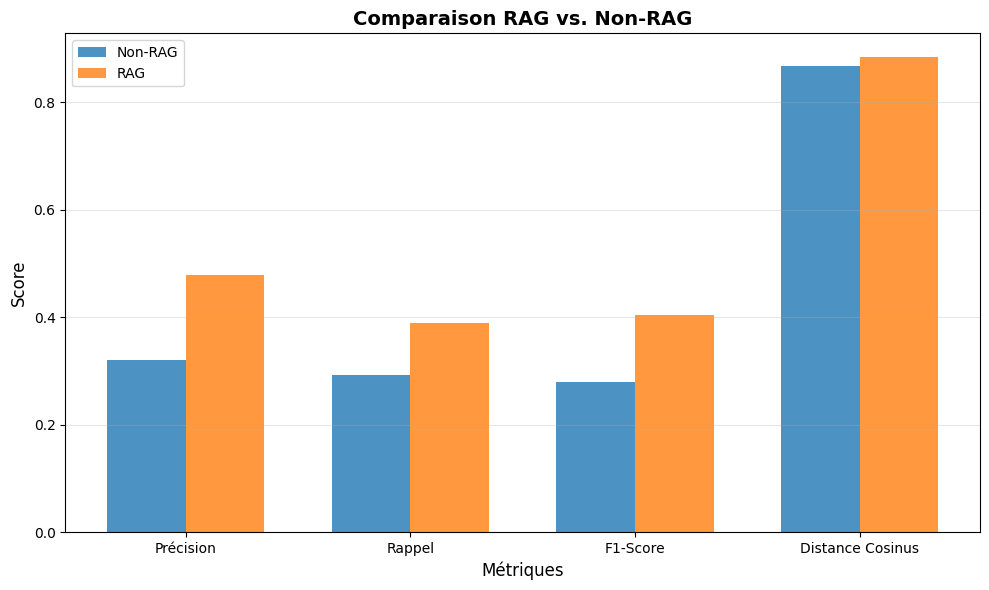

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Calcul des métriques globales à partir des résultats bruts
no_rag_eval = evaluation_generation(no_rag_results)
rag_eval = evaluation_generation(rag_results)

# Crée un tableau comparatif
comparison_df = pd.DataFrame({
    'Métrique': ['Précision', 'Rappel', 'F1-Score', 'Distance Cosinus'],
    'Non-RAG': [
        no_rag_eval['precision'],
        no_rag_eval['recall'],
        no_rag_eval['f1'],
        no_rag_eval['distance']
    ],
    'RAG': [
        rag_eval['precision'],
        rag_eval['recall'],
        rag_eval['f1'],
        rag_eval['distance']
    ]
})

# Calcule l'amélioration relative (en %)
def safe_relative_improvement(non_rag, rag):
    if non_rag == 0:
        return float('nan')
    return (rag - non_rag) / non_rag * 100

comparison_df['Amélioration (%)'] = [
    round(safe_relative_improvement(comparison_df['Non-RAG'][i],
                                    comparison_df['RAG'][i]), 2)
    for i in range(len(comparison_df))
]

print("\n" + "="*80)
print("TABLEAU COMPARATIF DES PERFORMANCES")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualisation
os.makedirs("results", exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(comparison_df['Métrique']))
width = 0.35

ax.bar([i - width/2 for i in x], comparison_df['Non-RAG'], width, label='Non-RAG', alpha=0.8)
ax.bar([i + width/2 for i in x], comparison_df['RAG'], width, label='RAG', alpha=0.8)

ax.set_xlabel('Métriques', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison RAG vs. Non-RAG', fontsize=14, fontweight='bold')
ax.set_xticks(list(x))
ax.set_xticklabels(comparison_df['Métrique'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

#### Analyse quantitative des résultats :

Sans RAG :
- Précision : 0.321
- Rappel : 0.293
- F1 : 0.280
- Similarité cosinus : 0.868

Avec RAG :
- Précision : 0.479
- Rappel : 0.390
- F1 : 0.404
- Similarité cosinus : 0.884

Lecture immédiate

1.	Gain net du RAG
- +44 % en F1 (0.28 → 0.40)
- +49 % en précision
- +33 % en rappel

=> Le RAG améliore à la fois l’exactitude lexicale et la couverture.

2. Précision augmente plus que rappel
- Le RAG réduit fortement les réponses hors-sujet (hallucinations).
- Le modèle devient plus conservateur mais plus juste.

3. La similarité cosinus s'améliore légèrement
- Même lorsque la réponse n’est pas exacte, elle est sémantiquement plus proche de la vérité.
- Typique des erreurs du type :
  - “medical man” vs “doctor”
  - “hansom” vs “hansom cab”

4. Sans RAG : connaissance floue
- Confusions récurrentes :
	- lieux génériques (London vs Baker Street),
	- métiers généraux (detective vs consulting detective),
	- objets proches (hypodermic syringe vs magnifying glass).

Ainsi :

Le RAG agit comme un mécanisme de régularisation factuelle :
il réduit l’hallucination et rapproche le modèle du texte source, au prix d’un rappel parfois incomplet lorsque le passage pertinent n’est pas récupéré.

Allons au-delà des moyennes globales et observons la variabilité des performances question par question :


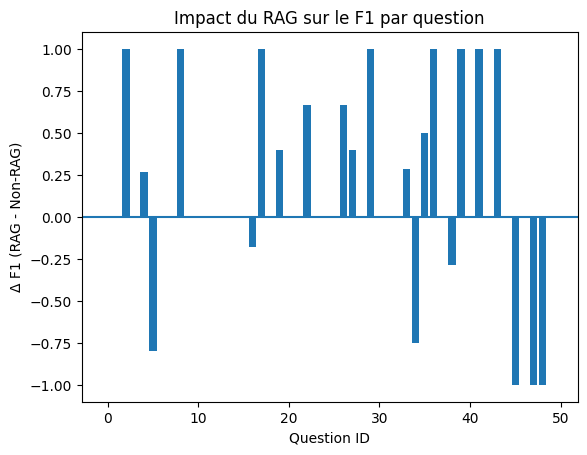

In [88]:
import pandas as pd

def per_question_f1(results):
    rows = []
    for i, q, ans, gt in results:
        _, _, f1 = evaluate_f1(gt, ans)
        rows.append({
            "id": i,
            "question": q,
            "f1": f1
        })
    return pd.DataFrame(rows)

df_no_rag = per_question_f1(no_rag_results)
df_rag = per_question_f1(rag_results)

df_compare = df_no_rag.copy()
df_compare["f1_rag"] = df_rag["f1"]
df_compare["delta_f1"] = df_compare["f1_rag"] - df_compare["f1"]

plt.figure()
plt.bar(df_compare["id"], df_compare["delta_f1"])
plt.axhline(0)
plt.xlabel("Question ID")
plt.ylabel("Δ F1 (RAG - Non-RAG)")
plt.title("Impact du RAG sur le F1 par question")
plt.show()

On remarque que la majorité des barres sont positives, preuve du gain global apporté par le RAG.

Néanmoins, il y a aussi des barres négatives de RAG et donc, bien que le RAG améliore globalement les performances, certaines dégradations ponctuelles sont observées. Elles s’expliquent par la dépendance accrue du modèle à la phase de récupération : lorsque les passages pertinents ne sont pas récupérés ou sont incomplets, le modèle, contraint de ne pas utiliser ses connaissances internes, peut produire une réponse incorrecte alors qu’une réponse correcte était possible sans RAG.

Ces erreurs illustrent un compromis classique du RAG entre réduction des hallucinations et sensibilité au retrieval. le RAG ne dégrade pas systématiquement, mais devient dépendant du contexte récupéré. Ces dégradations sont localisées, pas structurelles, comme le montre la comparaison des F1 par question.

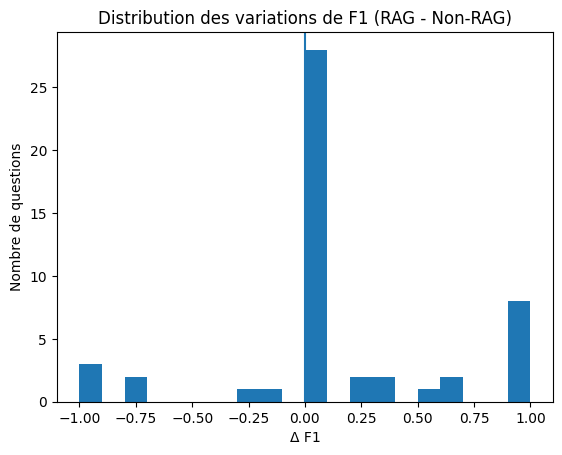

In [90]:
def compute_f1_per_question(results):
    f1s = {}
    for i, q, ans, gold in results:
        _, _, f1 = evaluate_f1(gold, ans)
        f1s[i] = f1
    return f1s

f1_no_rag = compute_f1_per_question(no_rag_results)
f1_rag = compute_f1_per_question(rag_results)

delta_f1 = {
    i: f1_rag.get(i, 0.0) - f1_no_rag.get(i, 0.0)
    for i in f1_no_rag.keys()
}

values = list(delta_f1.values())

plt.figure()
plt.hist(values, bins=20)
plt.axvline(0)
plt.title("Distribution des variations de F1 (RAG - Non-RAG)")
plt.xlabel("Δ F1")
plt.ylabel("Nombre de questions")
plt.show()

Comparons donc en détail et de manière qualitative les deux modèles.

## 8. Analyse des résultats


La répartition des questions selon le signe de ΔF1 met en évidence trois catégories :
- RAG meilleur : 30 % des questions
- Non-RAG meilleur : 14 % des questions
- Performance identique : 56 % des questions

### RAG MEILLEUR :

In [98]:
# Filtrer les questions où le RAG améliore le F1
rag_better = df_compare[df_compare["delta_f1"] > 0].copy()

print(f"Nombre de questions où RAG est meilleur : {len(rag_better)} / {len(df_compare)}")
display(rag_better[["id", "question", "f1", "f1_rag", "delta_f1"]])

Nombre de questions où RAG est meilleur : 15 / 50


,id,question,f1,f1_rag,delta_f1
2,2,Who is considered 'The Woman' by Sherlock Holmes?,0.0,1.000000,1.000000
4,4,What is the primary occupation of Sherlock Hol...,0.4,0.666667,0.266667
8,8,What is the blue gemstone found inside a Chris...,0.0,1.000000,1.000000
17,17,What is the bog near Baskerville Hall called?,0.0,1.000000,1.000000
19,19,What kind of drawings form the code that Holme...,0.0,0.400000,0.400000
22,22,What does Sherlock Holmes keep in his Persian ...,0.0,0.666667,0.666667
26,26,What object ties Irene Adler to a scandal with...,0.0,0.666667,0.666667
27,27,What weapon does Dr. Watson often carry?,0.0,0.400000,0.400000
29,29,What is the missing racehorse’s name in the Da...,0.0,1.000000,1.000000
33,33,What does Watson call Holmes’ method of reason...,0.0,0.285714,0.285714


In [99]:
rag_better[["f1", "f1_rag", "delta_f1"]].describe()

,f1,f1_rag,delta_f1
count,15.000000,15.000000,15.000000
mean,0.060000,0.805714,0.745714
std,0.159463,0.266905,0.301222
min,0.000000,0.285714,0.266667
25%,0.000000,0.666667,0.450000
50%,0.000000,1.000000,1.000000
75%,0.000000,1.000000,1.000000
max,0.500000,1.000000,1.000000


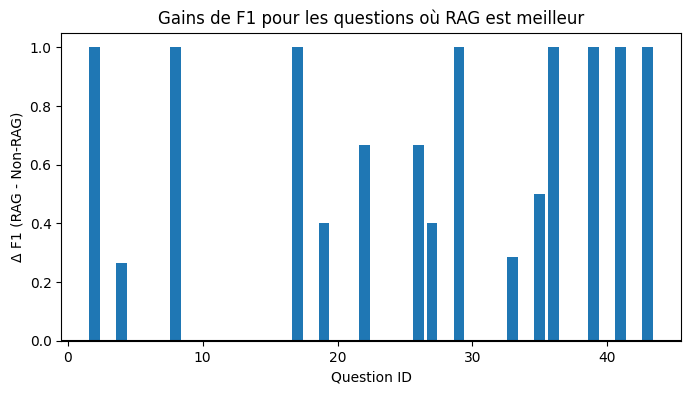

In [100]:
plt.figure(figsize=(8,4))
plt.bar(rag_better["id"], rag_better["delta_f1"])
plt.axhline(0, color="black")
plt.xlabel("Question ID")
plt.ylabel("Δ F1 (RAG - Non-RAG)")
plt.title("Gains de F1 pour les questions où RAG est meilleur")
plt.show()

#### Les questions pour lesquelles le RAG est meilleur partagent des caractéristiques communes :

#### 1. Informations factuelles précises
Il s’agit majoritairement de :
* **Noms propres** (personnages, clubs, institutions).
* **Objets ou lieux spécifiques du canon** (ex. *Blue Carbuncle*, *Grimpen Mire*).
* **Éléments uniques** difficilement déductibles par simple plausibilité.

**Dans ces cas :**
* Le modèle **sans RAG** produit des hallucinations plausibles ou des généralisations incorrectes.
* Le **RAG**, en revanche, fournit au modèle un passage explicite contenant la réponse exacte.


#### 2. Passage d’un raisonnement hypothétique à une extraction textuelle

**Sans RAG :**
* Le modèle raisonne à partir de connaissances internes floues.
* Il privilégie la cohérence sémantique plutôt que l’exactitude factuelle.

**Avec RAG :**
* La réponse est **directement ancrée dans le texte**.
* La génération devient **extractive**, non hypothétique.

> Le RAG agit ici comme un **verrou factuel**.



### Conclusion intermédiaire

Les cas où le RAG est meilleur correspondent donc à des questions factuelles précises pour lesquelles le modèle sans contexte échoue systématiquement.

Le RAG transforme ces échecs en succès exacts en fournissant un **ancrage textuel explicite**, ce qui se traduit par des gains élevés et discrets en F1, souvent égaux à +1.

### NORAG MEILLEUR

In [101]:
# Filtrer les questions où Non-RAG est meilleur
no_rag_better = df_compare[df_compare["delta_f1"] < 0].copy()

print(f"Nombre de questions où Non-RAG est meilleur : {len(no_rag_better)} / {len(df_compare)}")
display(no_rag_better[["id", "question", "f1", "f1_rag", "delta_f1"]])

Nombre de questions où Non-RAG est meilleur : 7 / 50


,id,question,f1,f1_rag,delta_f1
5,5,Who is Sherlock Holmes' arch-nemesis?,0.800000,0.00,-0.800000
16,16,What warning arrives as envelopes containing d...,0.181818,0.00,-0.181818
34,34,What is the name of the street‑boy network Hol...,1.000000,0.25,-0.750000
38,38,On what moor do the Baskerville events occur?,0.285714,0.00,-0.285714
45,45,What supernatural creature is suspected in a c...,1.000000,0.00,-1.000000
47,47,What handheld tool does Holmes use to inspect ...,1.000000,0.00,-1.000000
48,48,In which city do most of Holmes's cases take p...,1.000000,0.00,-1.000000


In [102]:
no_rag_better[["f1", "f1_rag", "delta_f1"]].describe()

,f1,f1_rag,delta_f1
count,7.000000,7.000000,7.000000
mean,0.752505,0.035714,-0.716790
std,0.363054,0.094491,0.346572
min,0.181818,0.000000,-1.000000
25%,0.542857,0.000000,-1.000000
50%,1.000000,0.000000,-0.800000
75%,1.000000,0.000000,-0.517857
max,1.000000,0.250000,-0.181818


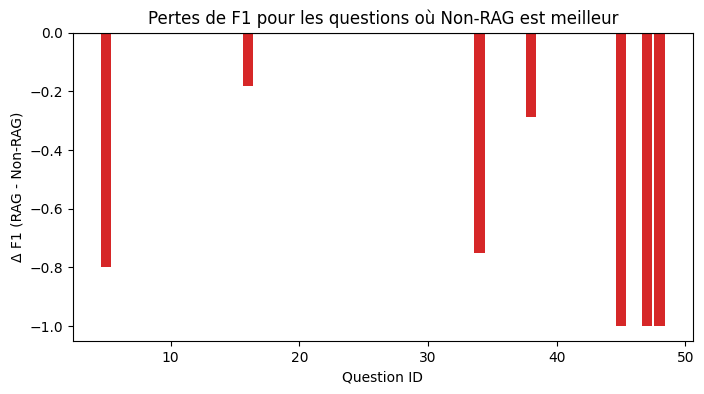

In [103]:
plt.figure(figsize=(8,4))
plt.bar(no_rag_better["id"], no_rag_better["delta_f1"], color="tab:red")
plt.axhline(0, color="black")
plt.xlabel("Question ID")
plt.ylabel("Δ F1 (RAG - Non-RAG)")
plt.title("Pertes de F1 pour les questions où Non-RAG est meilleur")
plt.show()

### Sur les 50 questions évaluées, 7 questions (14 %) présentent une performance supérieure sans RAG.

Les statistiques associées sont très parlantes :

* **F1 Non-RAG moyen :** 0.75
* **F1 RAG moyen :** 0.04
* **Perte moyenne $\Delta F1$ :** $-0.72$
* **Médiane du $\Delta F1$ :** $-0.80$

> Dans **4 cas sur 7**, le F1 chute de **1.0 à 0.0** avec RAG.

** Lecture quantitative**
Lorsque le Non-RAG est meilleur, la dégradation induite par le RAG est **forte et brutale**, pas marginale.



### Analyse qualitative (pourquoi le Non-RAG gagne)

Les cas où le Non-RAG surpasse le RAG se répartissent en trois mécanismes récurrents.

#### 1. Échec de retrieval (absence du passage clé)

Plusieurs questions concernent des faits **bien connus et globaux** :
* *arch-nemesis* $\rightarrow$ *Moriarty*
* *city of most cases* $\rightarrow$ *London*
* *supernatural creature* $\rightarrow$ *vampire*
* *inspection tool* $\rightarrow$ *magnifying glass*

**Dans ces cas :**
* Le **passage pertinent n’est pas récupéré** dans le top-k.
* Le modèle RAG, contraint par le prompt, **n’ose pas utiliser sa connaissance interne**.
* Il produit alors une réponse incorrecte ou trop locale.

> **Sans RAG, le modèle répond correctement par mémoire.**

#### 2. Sur-spécification induite par le contexte

Certaines dégradations proviennent d’une **interprétation trop locale du passage récupéré** :
* *London* $\rightarrow$ *Baker Street*
* *moor* $\rightarrow$ *Baskerville moor* (au lieu de *Dartmoor*)

Le RAG pousse le modèle à répondre avec un **détail présent dans le passage**, même s’il ne correspond pas exactement à la portée de la question.

> **Le Non-RAG, moins contraint, généralise mieux.**

#### 3. Connaissances « universelles » déjà bien apprises

Les questions où le Non-RAG excelle sont souvent :
* Extrêmement fréquentes dans le pré-entraînement.
* Fortement associées au personnage de Sherlock Holmes.

**Dans ces cas :**
* Le RAG **n’apporte aucune information nouvelle**.
* Il peut même introduire du bruit ou détourner la réponse.

> **Le RAG devient ici inutile, voire nuisible.**


### Conclusion intermédiaire

Les cas où le Non-RAG est meilleur correspondent principalement à des échecs de récupération ou à une sur-spécification induite par le contexte.

Lorsque la réponse est déjà solidement ancrée dans la connaissance interne du modèle et que le passage pertinent n’est pas récupéré, **le RAG contraint la génération et entraîne des dégradations marquées du F1**.

### Cas où les deux approches échouent

### On considère ici les questions pour lesquelles :

* **Non-RAG** et **RAG** obtiennent tous deux un **F1 $\le$ 0.1**
* Donc aucune des deux approches ne produit une réponse lexicalement correcte.

Sur les 50 questions évaluées, ce cas concerne :

> **18 questions (36 % du corpus)**

Ce taux non négligeable montre que le RAG **ne résout pas tous les types d’erreurs**, et que certaines difficultés sont structurelles.

In [ ]:
import pandas as pd

def per_question_f1(results):
    rows = []
    for i, q, ans, gt in results:
        _, _, f1 = evaluate_f1(gt, ans)
        rows.append({"id": i, "question": q, "f1": f1})
    return pd.DataFrame(rows)

df_no_rag = per_question_f1(no_rag_results)
df_rag    = per_question_f1(rag_results).rename(columns={"f1": "f1_rag"})

df_compare = df_no_rag.merge(df_rag[["id", "f1_rag"]], on="id", how="inner")
df_compare["delta_f1"] = df_compare["f1_rag"] - df_compare["f1"]

def categorize_delta(x):
    if x > 0: return "RAG better"
    if x < 0: return "Non-RAG better"
    return "Same"

df_compare["category"] = df_compare["delta_f1"].apply(categorize_delta)
df_compare.head()

In [ ]:
from sentence_transformers import util

def per_question_cos(results):
    rows = []
    for i, q, ans, gt in results:
        a = emb_model.encode(f"text: {ans}", normalize_embeddings=True)
        h = emb_model.encode(f"text: {gt}",  normalize_embeddings=True)
        cos = float(util.cos_sim(a, h))
        rows.append({"id": i, "question": q, "cos": cos})
    return pd.DataFrame(rows)

df_no_rag_cos = per_question_cos(no_rag_results).rename(columns={"cos": "cos_no_rag"})
df_rag_cos    = per_question_cos(rag_results).rename(columns={"cos": "cos_rag"})

df_sem = df_compare.merge(df_no_rag_cos[["id","cos_no_rag"]], on="id", how="inner") \
                   .merge(df_rag_cos[["id","cos_rag"]],     on="id", how="inner")

df_sem["delta_cos"] = df_sem["cos_rag"] - df_sem["cos_no_rag"]
df_sem.head()

In [104]:

F1_FAIL_TH = 0.1
COS_HIGH_TH = 0.85

df_double_fail = df_sem[(df_sem["f1"] <= F1_FAIL_TH) & (df_sem["f1_rag"] <= F1_FAIL_TH)].copy()
df_double_fail = df_double_fail.sort_values(["f1_rag", "cos_rag"], ascending=[True, False])

print(f"Nombre de questions où les deux échouent (F1 <= {F1_FAIL_TH}): {len(df_double_fail)} / {len(df_sem)}")

display(df_double_fail[["id","question","f1","f1_rag","delta_f1","cos_no_rag","cos_rag","delta_cos"]].head(20))

Nombre de questions où les deux échouent (F1 <= 0.1): 18 / 50


,id,question,f1,f1_rag,delta_f1,cos_no_rag,cos_rag,delta_cos
42,42,What scientific field is Holmes notably skille...,0.0,0.0,0.0,0.878007,0.920547,0.042540
9,9,What residue does Holmes often analyze to iden...,0.0,0.0,0.0,0.812810,0.898422,0.085612
11,11,What was the profession of Dr. John Watson?,0.0,0.0,0.0,0.917356,0.896529,-0.020827
28,28,In which country did Dr. Watson serve as an ar...,0.0,0.0,0.0,0.887549,0.887549,0.000000
25,25,What hot drink is often served at Baker Street?,0.0,0.0,0.0,0.790258,0.883180,0.092922
31,31,In which English county do Holmes and Watson i...,0.0,0.0,0.0,0.849364,0.880288,0.030924
40,40,In which county is Dartmoor located?,0.0,0.0,0.0,0.930110,0.875529,-0.054581
18,18,Which London newspaper does Holmes frequently ...,0.0,0.0,0.0,0.856687,0.872595,0.015908
46,46,What quick message service does Holmes often use?,0.0,0.0,0.0,0.860708,0.842912,-0.017797
37,37,What injury does Victor Hatherley suffer durin...,0.0,0.0,0.0,0.840847,0.841811,0.000963


In [105]:
df_double_fail_highcos = df_double_fail[df_double_fail["cos_rag"] >= COS_HIGH_TH].copy()
df_double_fail_lowcos  = df_double_fail[df_double_fail["cos_rag"] <  COS_HIGH_TH].copy()

print(f"Double fail + cos élevé (>= {COS_HIGH_TH}): {len(df_double_fail_highcos)}")
print(f"Double fail + cos faible (<  {COS_HIGH_TH}): {len(df_double_fail_lowcos)}")

print("\nExemples (cos élevé) — erreurs souvent lexicales / génériques :")
display(df_double_fail_highcos[["id","question","f1_rag","cos_rag"]].head(10))

print("\nExemples (cos faible) — erreurs de fond / hors sujet :")
display(df_double_fail_lowcos[["id","question","f1_rag","cos_rag"]].head(10))

Double fail + cos élevé (>= 0.85): 8
Double fail + cos faible (<  0.85): 10

Exemples (cos élevé) — erreurs souvent lexicales / génériques :


,id,question,f1_rag,cos_rag
42,42,What scientific field is Holmes notably skille...,0.0,0.920547
9,9,What residue does Holmes often analyze to iden...,0.0,0.898422
11,11,What was the profession of Dr. John Watson?,0.0,0.896529
28,28,In which country did Dr. Watson serve as an ar...,0.0,0.887549
25,25,What hot drink is often served at Baker Street?,0.0,0.883180
31,31,In which English county do Holmes and Watson i...,0.0,0.880288
40,40,In which county is Dartmoor located?,0.0,0.875529
18,18,Which London newspaper does Holmes frequently ...,0.0,0.872595



Exemples (cos faible) — erreurs de fond / hors sujet :


,id,question,f1_rag,cos_rag
46,46,What quick message service does Holmes often use?,0.0,0.842912
37,37,What injury does Victor Hatherley suffer durin...,0.0,0.841811
10,10,What tactic besides observation does Holmes of...,0.0,0.835168
12,12,What kind of marks on the ground does Holmes o...,0.0,0.806177
44,44,What railway timetable does Holmes often consult?,0.0,0.778462
49,49,"After retirement, what hobby does Holmes pursue?",0.0,0.766823
23,23,In which room at 221B do most client interview...,0.0,0.765975
24,24,What important document goes missing from the ...,0.0,0.762747
32,32,Where does Holmes retire?,0.0,0.738423
20,20,What kind of jewel is set in the damaged coron...,0.0,0.735980


### Analyse quantitative : F1 vs similarité cosinus

Bien que le F1 soit nul pour ces questions, la **similarité cosinus varie fortement**, ce qui permet de distinguer deux sous-catégories :

* **8 cas** avec similarité cosinus **élevée ($\ge$ 0.85)**
* **10 cas** avec similarité cosinus **faible (< 0.85)**

> Cela indique que **tous les échecs ne sont pas de même nature.**

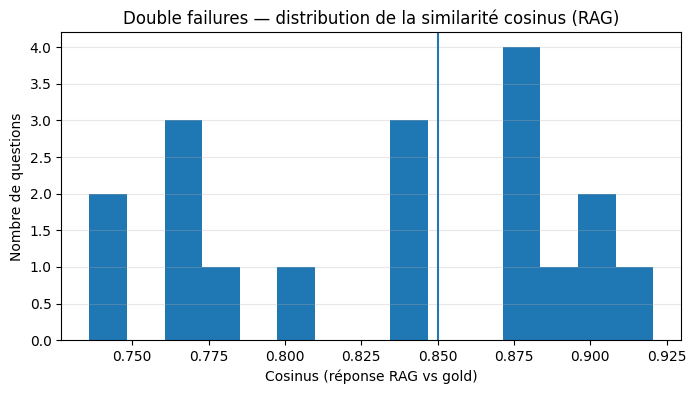

In [106]:
plt.figure(figsize=(8,4))
plt.hist(df_double_fail["cos_rag"], bins=15)
plt.axvline(COS_HIGH_TH)
plt.title("Double failures — distribution de la similarité cosinus (RAG)")
plt.xlabel("Cosinus (réponse RAG vs gold)")
plt.ylabel("Nombre de questions")
plt.grid(axis="y", alpha=0.3)
plt.show()

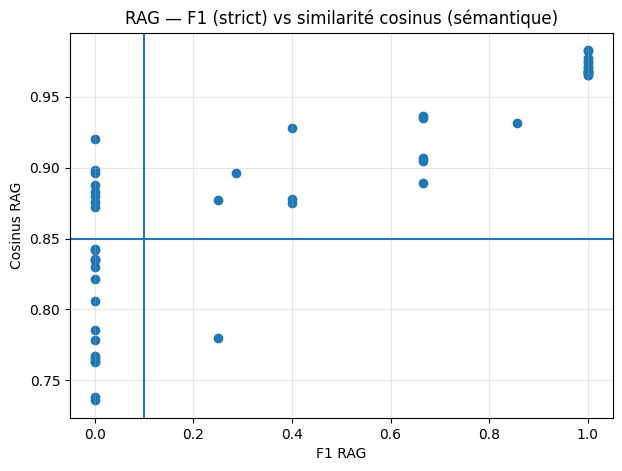

In [107]:
plt.figure(figsize=(7,5))
plt.scatter(df_sem["f1_rag"], df_sem["cos_rag"])
plt.axvline(F1_FAIL_TH)
plt.axhline(COS_HIGH_TH)
plt.title("RAG — F1 (strict) vs similarité cosinus (sémantique)")
plt.xlabel("F1 RAG")
plt.ylabel("Cosinus RAG")
plt.grid(alpha=0.3)
plt.show()

In [108]:
def show_examples(ids, no_rag_results, rag_results, n=5):
    no_map = {i:(q,a,g) for i,q,a,g in no_rag_results}
    ra_map = {i:(q,a,g) for i,q,a,g in rag_results}

    for k, i in enumerate(ids[:n]):
        q_no, a_no, g_no = no_map[i]
        q_ra, a_ra, g_ra = ra_map[i]
        print("="*90)
        print(f"Q{i}: {q_no}")
        print(f"Gold:    {g_no}")
        print(f"Non-RAG: {a_no}")
        print(f"RAG:     {a_ra}")

# Exemples: prendre 3 "cos élevé" + 3 "cos faible"
ids_high = df_double_fail_highcos["id"].tolist()
ids_low  = df_double_fail_lowcos["id"].tolist()

print("=== Double failures avec cos élevé (souvent mismatch lexical) ===")
show_examples(ids_high, no_rag_results, rag_results, n=3)

print("\n=== Double failures avec cos faible (erreurs de fond) ===")
show_examples(ids_low, no_rag_results, rag_results, n=3)

=== Double failures avec cos élevé (souvent mismatch lexical) ===
Q42: What scientific field is Holmes notably skilled in?
Gold:    Chemistry.
Non-RAG: Psychology
RAG:     science
Q9: What residue does Holmes often analyze to identify smokers?
Gold:    Tobacco ash.
Non-RAG: The microscope
RAG:     cigarettes
Q11: What was the profession of Dr. John Watson?
Gold:    Doctor.
Non-RAG: Surgeon
RAG:     medical man

=== Double failures avec cos faible (erreurs de fond) ===
Q46: What quick message service does Holmes often use?
Gold:    Telegrams.
Non-RAG: The telephone
RAG:     Holmes often uses a quick message service called "telegram
Q37: What injury does Victor Hatherley suffer during his adventure?
Gold:    Loss of a thumb.
Non-RAG: The injury is a broken leg
RAG:     His head was injured
Q10: What tactic besides observation does Holmes often use to gather information?
Gold:    Disguise.
Non-RAG: The art of deduction
RAG:     deduction


#### 1. Double échec avec similarité cosinus élevée
*(erreurs lexicales / génériques)*

**Dans ces cas :**
* Le F1 est nul (mismatch exact).
* Mais la réponse générée reste **sémantiquement proche** de la vérité.

**Exemple typique :**
* **Gold :** *Chemistry*
* **RAG :** *science*
* **Non-RAG :** *psychology*

**Ici :**
* Le modèle a identifié le **bon champ conceptuel**.
* Mais n’a pas produit la **forme canonique exacte** attendue.

**Interprétation :**
Ces erreurs proviennent principalement de :
* Réponses **trop générales** (*science*, *medical man*).
* **Synonymes ou hyperonymes** acceptables pour un humain.
* Mais pénalisés par une métrique F1 stricte.

> Le double échec n’est pas toujours une erreur de compréhension, mais souvent une **approximation lexicale** que le F1 ne capture pas, alors que la similarité cosinus le révèle.


#### 2. Double échec avec similarité cosinus faible
*(erreurs de fond / hors sujet)*

**Dans ces cas :**
* Le F1 est nul.
* Et **la similarité cosinus est basse**.
* Indiquant une **mauvaise compréhension du fait demandé**.

**Exemple typique :**
* **Gold :** *Loss of a thumb*
* **RAG :** *His head was injured*
* **Non-RAG :** *broken leg*

**Ici :**
* Ni le modèle sans RAG, ni le modèle avec RAG ne parviennent à identifier le **bon événement narratif**.

**Causes probables :**
Ces erreurs sont liées à :
* Passages absents ou mal récupérés (RAG).
* Ambiguïtés narratives fortes.
* Questions nécessitant un **raisonnement inter-passages**.
* Ou des détails peu saillants dans le texte.

> Ces cas représentent les **limites intrinsèques** du pipeline actuel, indépendamment du RAG.



Les cas où **les deux approches échouent** révèlent deux phénomènes distincts :

1.  **Échecs “superficiels”**
    * Compréhension correcte.
    * Réponse proche sémantiquement.
    * Pénalisée par une évaluation stricte.
2.  **Échecs “profonds”**
    * Mauvaise compréhension factuelle.
    * Récupération insuffisante.
    * Ou limitation du modèle génératif.

Le RAG réduit les hallucinations et améliore la factualité, mais **ne suffit pas** lorsque l’information est absente, ambiguë ou mal formulée dans le contexte récupéré.



L’analyse des doubles échecs montre que :

* Le F1 seul est insuffisant pour juger la qualité réelle des réponses.
* La similarité cosinus apporte une **lecture complémentaire essentielle**.
* Le RAG améliore la précision factuelle, mais **ne corrige pas tous les types d’erreurs**, en particulier celles liées à la granularité lexicale ou à des lacunes de retrieval.

## CONCLUSION

Ce travail pratique avait pour objectif d’étudier de manière expérimentale l’impact des choix de conception d’un système de question-réponse, en comparant une approche **Non-RAG** (réponse basée uniquement sur les connaissances internes du modèle) et une approche **RAG** (réponse conditionnée par des passages externes récupérés).

En s’appuyant sur le modèle **SmolLM2-1.7B-Instruct**, volontairement de taille modérée, nous avons pu mettre en évidence de manière claire les **forces, limites et compromis** associés à chacune de ces approches, sans que les performances d’un très grand modèle ne masquent les phénomènes étudiés.


#### 1. Apports principaux du RAG

Les résultats quantitatifs montrent un **gain net du RAG** :

* **+44 %** en F1
* **+49 %** en précision
* **+33 %** en rappel
* Amélioration légère mais cohérente de la similarité cosinus.

**Interprétation :**
Ces gains s’expliquent par la capacité du RAG à **corriger des erreurs factuelles** du modèle Non-RAG lorsque l’information est explicitement présente dans les passages récupérés. Le RAG agit alors comme un **ancrage textuel**, réduisant fortement les hallucinations et les confusions d’entités (personnages, objets, lieux).

> Sur les questions où le modèle sans contexte échoue complètement (F1 = 0), le RAG permet fréquemment d’atteindre une réponse exacte (F1 = 1), démontrant l’intérêt du retrieval pour les connaissances fines et peu stéréotypées.


#### 2. Limites du RAG et dépendance au retrieval

L’analyse fine par question révèle cependant que le RAG **ne constitue pas une amélioration systématique**. Dans environ **14 % des cas**, le modèle Non-RAG surpasse le RAG.

Ces dégradations sont directement liées à :
* Des échecs de récupération (passages absents, partiels ou hors sujet).
* Une contrainte volontairement stricte imposée au modèle RAG, qui l’empêche d’exploiter ses connaissances internes lorsque le contexte est défaillant.

> **Constat :** Le RAG introduit une **dépendance structurelle à la qualité du retrieval** : lorsque celui-ci échoue, le modèle peut produire une réponse incorrecte là où le Non-RAG réussissait.


#### 3. Rôle complémentaire du F1 et de la similarité cosinus

L’utilisation conjointe du **F1-score** et de la **similarité cosinus** s’est révélée essentielle pour une analyse nuancée :

* Le **F1** mesure la correction lexicale stricte.
* Le **cosinus** met en évidence des réponses **sémantiquement proches** mais lexicalement incorrectes.

Cette distinction permet d’identifier deux types d’erreurs :
1.  Des erreurs superficielles (lexicales, synonymes, formulations proches).
2.  Des erreurs de fond (mauvaise entité, mauvais fait).

Elle montre également que, même en cas d’échec strict (F1 = 0), le RAG tend à rapprocher la réponse du bon concept, ce que le Non-RAG ne garantit pas.


#### 4. Enseignements généraux

Ce TP met en évidence un compromis fondamental du RAG :

* **Non-RAG :** Plus autonome, mais plus sujet aux hallucinations et aux confusions factuelles.
* **RAG :** Plus fiable factuellement, mais dépendant de la qualité du retrieval et du chunking.

Le RAG ne remplace donc pas les connaissances internes du modèle, mais agit comme un **mécanisme de régularisation factuelle**, particulièrement efficace pour des questions précises et vérifiables.

### 5. Sensibilité et limites des petits modèles face au prompting

L’utilisation de **SmolLM2-1.7B-Instruct**, modèle de taille relativement réduite, met également en lumière un point central du cours : la **forte sensibilité des petits modèles au design du prompt**.

Contrairement aux très grands modèles, SmolLM2 :
* Respecte les contraintes **de manière imparfaite**.
* A tendance à **sur-générer** (phrases complètes, reformulations) malgré des instructions explicites.
* Peut **ignorer ou mal hiérarchiser** certaines règles lorsque le prompt devient complexe (RAG + contraintes strictes + format imposé).

**Cette sensibilité se manifeste concrètement par :**
* Des réponses trop longues malgré la consigne *“answer span only”*.
* Des réponses sémantiquement plausibles mais **non présentes textuellement** dans les passages RAG.
* Des violations ponctuelles du fallback *“I don’t know”*.

> **Limite structurelle observée :** Ces comportements illustrent que les petits modèles suivent les instructions **de façon heuristique**, et non comme des contraintes logiques strictes.


#### Conséquences pratiques

Cela explique pourquoi :
1.  Le **post-traitement** (nettoyage des préfixes, tronquage) est indispensable.
2.  Des choix de prompt très précis (ordre des règles, formulation, exemples) ont un impact mesurable sur les performances.

**Dans le cadre du RAG, cette limitation est amplifiée :**
Le modèle doit gérer une surcharge cognitive en devant simultanément :
* Comprendre la question,
* Analyser le contexte injecté,
* Résister à ses connaissances internes,
* Et **respecter un format strict**.

Un petit modèle peut échouer à satisfaire simultanément toutes ces contraintes, là où un modèle plus large les absorberait plus facilement.

> **Conclusion de la section :** Ce TP montre que le RAG n’est pas uniquement un problème de retrieval ou d’indexation, mais aussi un **problème de capacité du modèle à exploiter correctement le contexte et les instructions**.


#### 6. Perspectives

Enfin, ce travail souligne que la performance d’un système RAG ne dépend pas uniquement du modèle génératif, mais aussi — et parfois surtout — de :
* La stratégie de chunking,
* Le modèle d’embedding,
* La qualité de l’indexation,
* Le choix de top-k,
* Et le design du prompt.

Ces éléments constituent des leviers majeurs d’amélioration et ouvrent la voie à des travaux futurs combinant : **retrieval adaptatif, reranking, hybridation RAG / Non-RAG**, ou encore **validation explicite** des passages utilisés pour la réponse.

> **En résumé :** Le RAG apparaît non pas comme une solution universelle, mais comme un **outil puissant lorsqu’il est correctement maîtrisé**, illustrant parfaitement les enjeux modernes du question-réponse en NLP.